<a href="https://colab.research.google.com/github/Murthy-Kolluru/modelthinking/blob/main/SchellingSA_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import time

# Record the start time
start_time = time.time()
# Your code or operations here
# ...


In [ ]:
def create_df(size, occupancy_percentage):
    num_occupied = int((size ** 2) * occupancy_percentage / 100)

    # Simplified the creation of the 'Occupied' array
    occupied_cells = np.concatenate([np.ones(num_occupied), np.zeros(size ** 2 - num_occupied)])
    np.random.shuffle(occupied_cells)

    df = pd.DataFrame({'ID': range(1, size ** 2 + 1), 'Occupied': occupied_cells})

    # Simplified the populate_properties function
    df['fin_pref'] = np.where(df['Occupied'] == 1, np.random.randint(1, 3, size=df.shape[0]), 0)
    df['rel_pref'] = df['fin_pref']
    df['acad_pref'] = df['fin_pref']

    return df

In [ ]:
#An occupied agent moves to an unoccupied spot to create a neighboring state
def create_neighbor(df, print_selected_rows=False):
    # Make a copy of the DataFrame to avoid modifying the original one
    df_1 = df.copy()

    # Select one row with Occupied=1 and another with Occupied=0
    occupied_indices = df[df['Occupied'] == 1].index
    unoccupied_indices = df[df['Occupied'] == 0].index

    if len(occupied_indices) == 0 or len(unoccupied_indices) == 0:
        # If there are no rows with Occupied=1 or Occupied=0, return original DataFrame
        return df_1, df_1

    occupied_index = np.random.choice(occupied_indices)
    unoccupied_index = np.random.choice(unoccupied_indices)
    print_selected_rows=True

    # Swap the values of fin_pref, rel_pref, and acad_pref between the two rows
    df_1.loc[occupied_index, ['fin_pref', 'rel_pref', 'acad_pref']], df_1.loc[unoccupied_index, ['fin_pref', 'rel_pref', 'acad_pref']] = \
    df_1.loc[unoccupied_index, ['fin_pref', 'rel_pref', 'acad_pref']].values, df_1.loc[occupied_index, ['fin_pref', 'rel_pref', 'acad_pref']].values

    # Swap the Occupied status df_1.at[occupied_index, 'Occupied'] = 0

    df_1.at[unoccupied_index, 'Occupied'] = 1
    df_1.at[occupied_index, 'Occupied'] = 0

    # Swap occupied and unoccpied indices also
    temp = occupied_index
    occupied_index = unoccupied_index
    unoccupied_index = temp

    return df, df_1, occupied_index, unoccupied_index



In [ ]:
#Plot the grid

import numpy as np
import matplotlib.pyplot as plt

def plot_grid(df):
    # Extracting relevant columns
    occupied = df['Occupied']
    fin_pref = df['fin_pref']
    acad_pref = df['acad_pref']
    rel_pref = df['rel_pref']

    # Calculate grid dimensions
    grid_size = int(np.sqrt(len(df)))

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Reshape data into a square grid
    occupied_grid = occupied.values.reshape((grid_size, grid_size))
    fin_pref_grid = fin_pref.values.reshape((grid_size, grid_size))
    acad_pref_grid = acad_pref.values.reshape((grid_size, grid_size))
    rel_pref_grid = rel_pref.values.reshape((grid_size, grid_size))

    # Plot for fin_pref
    ax = axes[0]
    ax.set_title('fin_pref')
    ax.imshow(fin_pref_grid, cmap='RdYlGn', interpolation='nearest')
    ax.imshow(np.ma.masked_where((occupied_grid == 1) & (fin_pref_grid == 1), np.ones_like(fin_pref_grid)), cmap='Reds', interpolation='nearest', alpha=0.5)
    ax.imshow(np.ma.masked_where((occupied_grid == 1) & (fin_pref_grid == 2), np.ones_like(fin_pref_grid)), cmap='Greens', interpolation='nearest', alpha=0.5)
    ax.imshow(np.ma.masked_where(occupied_grid == 0, np.ones_like(fin_pref_grid)), cmap='gray', interpolation='nearest', alpha=0.5)

    # Plot for acad_pref
    ax = axes[1]
    ax.set_title('acad_pref')
    ax.imshow(acad_pref_grid, cmap='RdYlGn', interpolation='nearest')
    ax.imshow(np.ma.masked_where((occupied_grid == 1) & (acad_pref_grid == 1), np.ones_like(acad_pref_grid)), cmap='Reds', interpolation='nearest', alpha=0.5)
    ax.imshow(np.ma.masked_where((occupied_grid == 1) & (acad_pref_grid == 2), np.ones_like(acad_pref_grid)), cmap='Greens', interpolation='nearest', alpha=0.5)
    ax.imshow(np.ma.masked_where(occupied_grid == 0, np.ones_like(acad_pref_grid)), cmap='gray', interpolation='nearest', alpha=0.5)

    # Plot for rel_pref
    ax = axes[2]
    ax.set_title('rel_pref')
    ax.imshow(rel_pref_grid, cmap='RdYlGn', interpolation='nearest')
    ax.imshow(np.ma.masked_where((occupied_grid == 1) & (rel_pref_grid == 1), np.ones_like(rel_pref_grid)), cmap='Reds', interpolation='nearest', alpha=0.5)
    ax.imshow(np.ma.masked_where((occupied_grid == 1) & (rel_pref_grid == 2), np.ones_like(rel_pref_grid)), cmap='Greens', interpolation='nearest', alpha=0.5)
    ax.imshow(np.ma.masked_where(occupied_grid == 0, np.ones_like(rel_pref_grid)), cmap='gray', interpolation='nearest', alpha=0.5)

    plt.tight_layout()
    plt.show()

#plot_grid(df)



In [ ]:
# Identifying the neighboring slots to compute happiness
def get_neighbors(size, agent_id):
    neighbors = {}
    agent_row, agent_col = divmod(agent_id, size)

    for i in range(agent_row - 1, agent_row + 2):
        for j in range(agent_col - 1, agent_col + 2):
            if 0 <= i < size and 0 <= j < size and not (i == agent_row and j == agent_col):
                neighbors[i * size + j] = True

    return list(neighbors.keys())


In [ ]:
def compute_agent_happiness(df, agent_id):

    # Check if the chosen agent's cell is unoccupied
    # if df.at[agent_id, 'Occupied'] == 0:
    #    total_happiness = 0
    #    return 0

    # This part of the code deals with Mutated dataframe (flagTypeOfDataFrame = True)
    # Extract preferences of the agent
    fin_pref = df.at[agent_id, 'fin_pref']
    acad_pref = df.at[agent_id, 'acad_pref']
    rel_pref = df.at[agent_id, 'rel_pref']

    # Initialize happiness variables
    fin_hap = 0
    acad_hap = 0
    rel_hap = 0
    neighb_hap = 0

    # Initialize temporary happiness variables
    fin_hap_temp = 0
    acad_hap_temp = 0
    rel_hap_temp = 0

    # Get neighbor grid IDs
    # Calculate the size of the grid
    grid_size = int(np.sqrt(len(df)))

    # Call get_neighbors with the grid size and agent ID
    neighbors = get_neighbors(grid_size, agent_id)

    # Drop neighbors where occupied value is 0
    valid_neighbors = [neighbor for neighbor in neighbors if df.at[neighbor, 'Occupied'] == 1]

    # Compute temporary happiness based on preferences
    for neighbor_id in valid_neighbors:
        neighbor_fin_pref = df.at[neighbor_id, 'fin_pref']
        neighbor_acad_pref = df.at[neighbor_id, 'acad_pref']
        neighbor_rel_pref = df.at[neighbor_id, 'rel_pref']

        if fin_pref == neighbor_fin_pref:
            fin_hap_temp += 1
        if acad_pref == neighbor_acad_pref:
            acad_hap_temp += 1
        if rel_pref == neighbor_rel_pref:
            rel_hap_temp += 1

    # Update happiness based on temporary happiness
    if fin_hap_temp >= 4:
        fin_hap += 1
    if acad_hap_temp >= 3:
        acad_hap += 1
    if rel_hap_temp >= 2:
        rel_hap += 1

    # Compute neighbor happiness (This twice as important as any other happiness.  Hence, I multipled with 2)
    neighb_hap = len(valid_neighbors) / 4

    # Compute total happiness
    total_happiness = fin_hap + acad_hap + rel_hap + neighb_hap

    return total_happiness

In [ ]:
#Iterate on all rows and fill a new column called total happiness for each agent
def fill_happiness_columns(df, size, flag, swapped_occupied_agent_id, swapped_empty_agent_id):

    # Define function to compute happiness for each row
    def compute_and_fill_happiness(row):
        # Check if the agent's cell is unoccupied
        if row['Occupied'] == 0:
            return 0  # If unoccupied, return zero for total_happiness
        else:
            # Compute happiness
            happiness_value = compute_agent_happiness(df, row.name)
            return happiness_value

    # Apply the function to each row to fill the columns
    if flag == False: # orginal dataframe
        df['total_happiness'] = df.apply(compute_and_fill_happiness, axis=1)

    if flag == True: # Mutated dataframe with only one mutation
       neighbors_For_Swapped_occupied_agent = get_neighbors(size, swapped_occupied_agent_id)
       neighbors_For_Swapped_empty_agent = get_neighbors(size, swapped_empty_agent_id)

       # First compute the updated total_happiness for these two swapped cells
       df.at[swapped_empty_agent_id, 'total_happiness'] = 0
       df.at[swapped_occupied_agent_id, 'total_happiness'] = compute_agent_happiness(df, swapped_occupied_agent_id)

       # Concatenate the lists
       neighbors_to_recompute = neighbors_For_Swapped_occupied_agent + neighbors_For_Swapped_empty_agent
       # Remove duplicates by converting to set
       result_set = set(neighbors_to_recompute)
       # Convert the set back to a list if needed
       final_neighbors_to_recompute = list(result_set)

       for each_neighbor_agent_id in final_neighbors_to_recompute:
            if df.at[each_neighbor_agent_id, 'Occupied'] == 0:
                df.at[each_neighbor_agent_id, 'total_happiness'] = 0
            else:
                df.at[each_neighbor_agent_id, 'total_happiness'] = compute_agent_happiness(df, each_neighbor_agent_id)

    return df



In [ ]:

#FInding Objective as count of agents that have more than threshold total_happiness
def calculate_objective(df, threshold):
    # Count rows with total happiness greater than or equal to the threshold
    objective = (df['total_happiness'] >= threshold).sum()
    return objective


In [ ]:
def select_df_based_on_temperature(T, df_1, df_2, threshold):
    # Compute objectives for both data frames
    obj1 = calculate_objective(df_1, threshold)
    obj2 = calculate_objective(df_2, threshold)

    # Print the objective values for both data frames
    #print("Objective value for df_1:", obj1)
    #print("Objective value for df_2:", obj2)

    # If df2 has higher objective, return df2
    if obj2 >= obj1:
        #print("Selected Selected DataFrame: df_2")
        return df_2

    # If df2 has lower objective, compute probability of selecting df2
    else:
        p = np.exp((obj2 - obj1) / T)
        #print("prob=", p)

        # Generate a random number between 0 and 1
        rand_num = np.random.rand()

        # If the random number is less than or equal to probability p, return df2
        if rand_num <= p:
            #print("Selected DataFrame: df_2")
            return df_2
        else:
            #print("Selected DataFrame: df_1")
            return df_1

In [ ]:
def print_params(size, occupancy_percentage, start_temps, iterations, geometric_factor, threshold) :
    print("\nsize = ", size)
    print("occupancy_percentage = ", occupancy_percentage)
    print("start_temps = ", start_temps)
    print("iterations = ", iterations)
    print("geometric_factor = ", geometric_factor)
    print("threshold = ", threshold)
    return


In [ ]:

import matplotlib.pyplot as plt

def main(size, occupancy_percentage, start_temps, iterations, geometric_factor, threshold):
    all_objective_values = []
    max_objectives = []
    for start_temp in start_temps:
        objective_values = []
        df = create_df(size, occupancy_percentage)
        #print(df)
        max_objective = float('-inf')
        temp = start_temp
        #print(df.head())

        # Calculate objective for the initial DataFrame and store it as the first objective value
        #initial_objective = calculate_objective(df)
        #objective_values.append(initial_objective)

        for iter_num in range(1, iterations + 1):
            n1, n2, swapped_occupied_agent_id, swapped_empty_agent_id = create_neighbor(df)
            #print("n1:", n1)
            #print("n2:", n2)

            flag = False # flag = 0 meaning original dataframe passed, 1 meaning permuted dataframe passed
            n1 = fill_happiness_columns(n1, size, flag, swapped_occupied_agent_id, swapped_empty_agent_id)  # Add the total_happiness column

            flag = not flag # Mutated dataframe is being passed (flag = 1)
            n2 = fill_happiness_columns(n2, size, flag, swapped_occupied_agent_id, swapped_empty_agent_id)

            # Find all indices which are still as 'NaN' (As they were not neighbors for recomputation)
            nan_indexes = df.loc[n2['total_happiness'].isna()].index.to_numpy()
            if nan_indexes.size > 0: # NaNs present
                # Use loc to replace NaNs only in specific rows with values from df2
                n2.loc[nan_indexes, 'total_happiness'] = n1.loc[nan_indexes, 'total_happiness']


            selected_df = select_df_based_on_temperature(temp, n1, n2, threshold)

            # Calculate and print the objective of the selected DataFrame every 10th iteration
            selected_objective = calculate_objective(selected_df, threshold)
            if iter_num % 10 == 0:
                print(f"Iteration {iter_num}, Temperature {temp}, Selected DataFrame Objective: {selected_objective}")

            # Update the maximum objective
            max_objective = max(max_objective, selected_objective)
            objective_values.append(selected_objective)

            df = selected_df.drop(columns=['total_happiness'])
            temp *= geometric_factor  # Update temperature

        max_objectives.append(max_objective)
        all_objective_values.append(objective_values)

        flag = False # Reset the flag after every iteration
        # del n1, n2

    # Print max objectives
    for i, max_obj in enumerate(max_objectives):
        print(f"Max Objective for Start Temp {start_temps[i]}: {max_obj}")

    # Plot objectives
    plt.figure(figsize=(10, 6))
    for i, obj_values in enumerate(all_objective_values):
        plt.plot(obj_values, label=f"Start Temp {start_temps[i]}")
    plt.xlabel('Iteration')
    plt.ylabel('Objective Value')
    plt.title('Objectives as a Function of Iteration')
    plt.legend()
    plt.show()






size =  30
occupancy_percentage =  90
start_temps =  [1, 10, 100]
iterations =  1000
geometric_factor =  0.95
threshold =  3.5
Iteration 10, Temperature 0.6302494097246091, Selected DataFrame Objective: 569
Iteration 20, Temperature 0.37735360253530714, Selected DataFrame Objective: 578
Iteration 30, Temperature 0.2259355409925655, Selected DataFrame Objective: 581
Iteration 40, Temperature 0.1352759542790559, Selected DataFrame Objective: 583
Iteration 50, Temperature 0.08099471081759278, Selected DataFrame Objective: 584
Iteration 60, Temperature 0.04849452524942309, Selected DataFrame Objective: 589
Iteration 70, Temperature 0.029035463617657853, Selected DataFrame Objective: 591
Iteration 80, Temperature 0.017384604615803764, Selected DataFrame Objective: 596
Iteration 90, Temperature 0.010408804957535735, Selected DataFrame Objective: 601
Iteration 100, Temperature 0.0062321360214042075, Selected DataFrame Objective: 605
Iteration 110, Temperature 0.0037314100463728015, Selected 

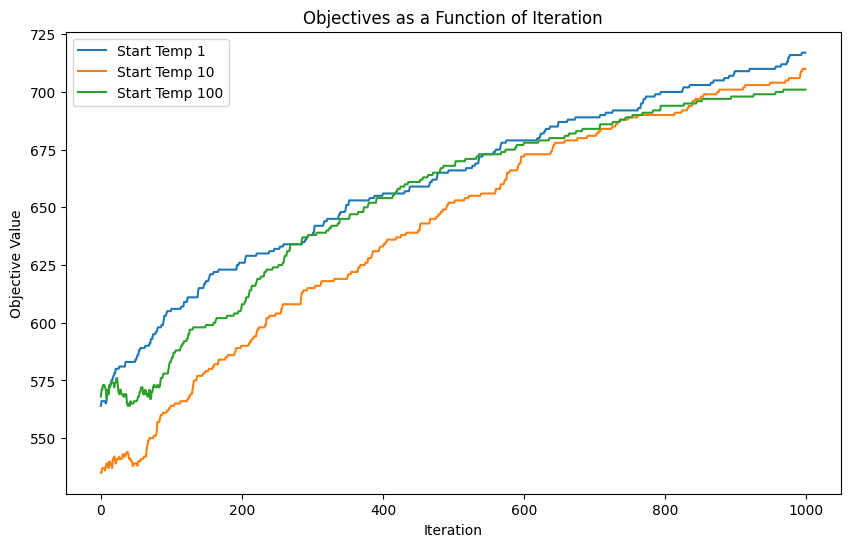

Elapsed Time: 514.5175111293793 seconds


In [ ]:
# Example Usage:
size = 30
occupancy_percentage = 90
start_temps = [1, 10, 100]
iterations = 1000
geometric_factor = 0.95
threshold = 3.5
print_params(size, occupancy_percentage, start_temps, iterations, geometric_factor, threshold)

# Call the main function
main(size, occupancy_percentage, start_temps, iterations, geometric_factor, threshold)


# Record the end time
end_time = time.time()
# Calculate the elapsed time duration in seconds
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time} seconds")